In [3]:
from src.modelmodule.seg import SegModel
from src.datamodule.seg import SegDataModule
from pytorch_lightning import Trainer, seed_everything
import matplotlib.pyplot as plt
import torch
from omegaconf import OmegaConf, DictConfig
import hydra

# 用于初始化 Hydra 并且合成配置的函数
def init_hydra():
    with hydra.initialize(config_path="temp/", version_base="1.2"):
        # 这里我们使用 compose 而不是 hydra.main
        cfg = hydra.compose(config_name="exp046")
        return cfg

# 执行代码
cfg = init_hydra()


seed_everything(cfg.seed)
print(cfg)
# 初始化 lightning 数据模块和模型
datamodule = SegDataModule(cfg)
model = SegModel(
    cfg, datamodule.valid_event_df, len(cfg.features), len(cfg.labels), cfg.duration
)
# weight_path = 'output/train/exp005/single/child-mind-institute-detect-sleep-states/itphhvr1/checkpoints/epoch=25-step=3094.ckpt'
# weight_path = 'output/train/exp005/single/best_model.pth'
# weight_path = 'output/train/exp026/run3/child-mind-institute-detect-sleep-states/s6956feb/checkpoints/epoch=26-step=4671.ckpt'
weight_path = 'output/train/exp046/single/best_model.pth'
spec2dcnn = model.model
spec2dcnn.load_state_dict(torch.load(weight_path))

Seed set to 3407


{'model_sigmod': False, 'output_sigmod': True, 'output_clip': False, 'seed': 3407, 'exp_name': 'exp046', 'duration': 17280, 'downsample_rate': 12, 'upsample_rate': 1, 'epoch': 50, 'batch_size': 8, 'num_workers': 24, 'accelerator': 'auto', 'use_amp': True, 'debug': False, 'gradient_clip_val': 0.1, 'accumulate_grad_batches': 1, 'monitor': 'val_score', 'monitor_mode': 'max', 'check_val_every_n_epoch': 1, 'offset': 10, 'sigma': 2, 'bg_sampling_rate': 0.5, 'augmentation': {'mixup_prob': 0.0, 'mixup_alpha': 0.4, 'cutmix_prob': 0.0, 'cutmix_alpha': 0.4}, 'post_process': {'score_th': 0.02, 'distance': 64}, 'labels': ['awake', 'event_onset', 'event_wakeup'], 'features': ['anglez', 'enmo', 'hour_sin', 'hour_cos'], 'optimizer': {'lr': 0.001}, 'scheduler': {'num_warmup_steps': 0}, 'loss': {'name': 'MSE'}, 'dir': {'data_dir': '/home/ljb/kaggle-child-mind-institute-detect-sleep-states/data', 'processed_dir': '/home/ljb/kaggle-child-mind-institute-detect-sleep-states/processed_data', 'output_dir': '/

<All keys matched successfully>

In [4]:
feature_extractor = spec2dcnn.feature_extractor
encoder = spec2dcnn.encoder
decoder = spec2dcnn.decoder

In [5]:
print(type(feature_extractor))
print(type(encoder))
print(type(decoder))

<class 'src.models.feature_extractor.mix.MixedFeatureExtractor'>
<class 'segmentation_models_pytorch.decoders.deeplabv3.model.DeepLabV3Plus'>
<class 'src.models.decoder.mix.MixedDecoder'>


In [6]:
train_dl = datamodule.val_dataloader()
batch = next(iter(train_dl)) #dict_keys(['series_id', 'feature', 'label'])

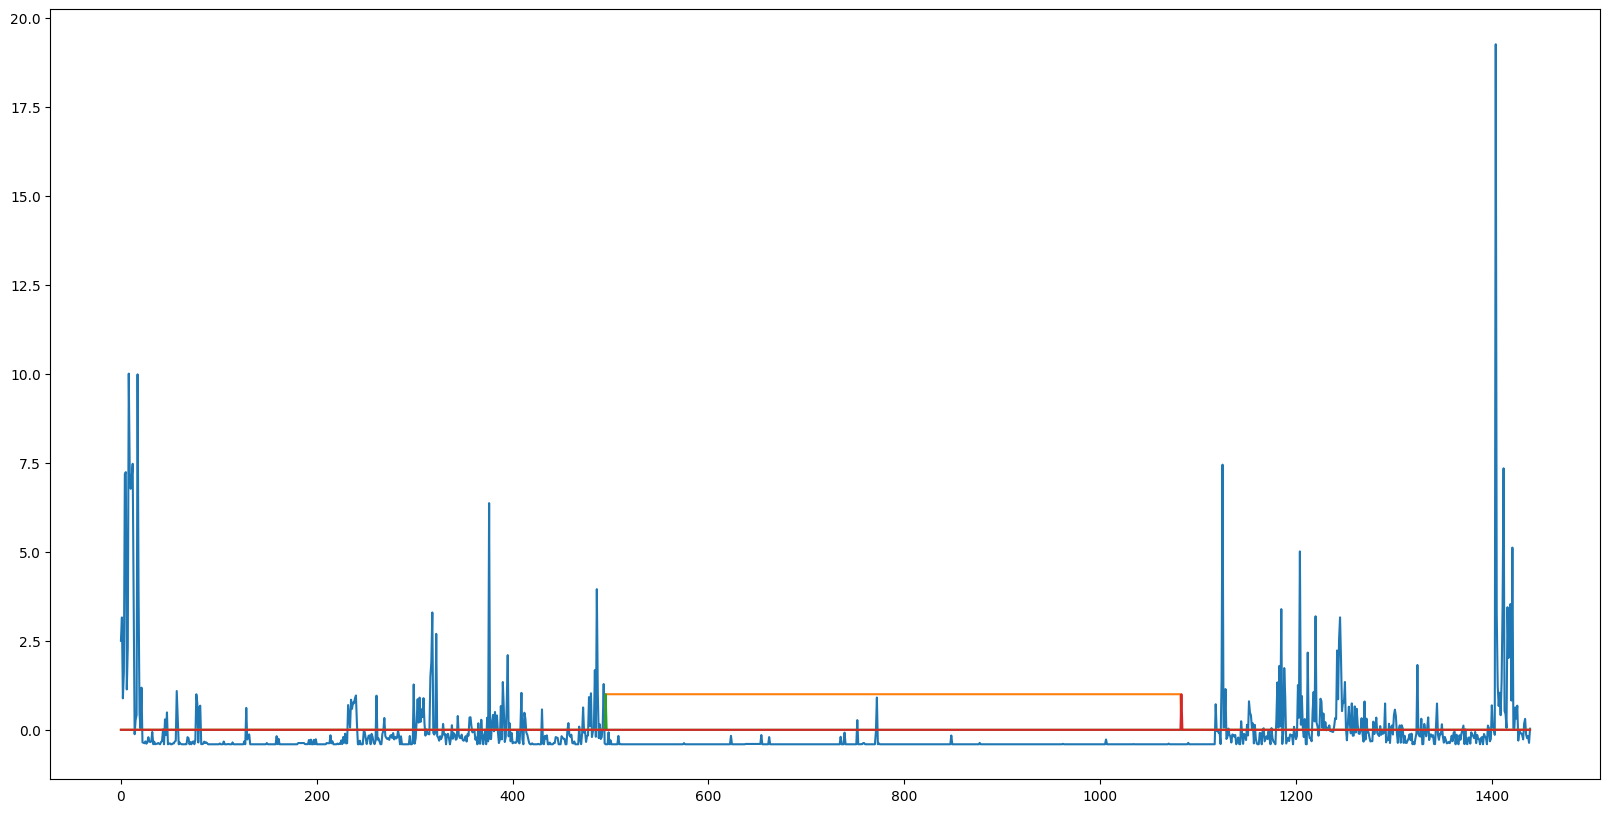

In [28]:
idx = 1
# s_id = batch['series_id'][idx]
x = batch['feature'][idx:idx+2]
y = batch['label'][idx]
fig = plt.figure(figsize=(20, 10))
plt.plot(x[idx, 1, ::cfg.downsample_rate])
plt.plot(y)
plt.show()

torch.Size([2, 10, 64, 1440])


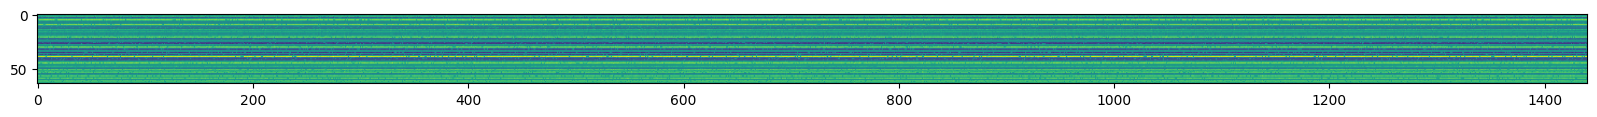

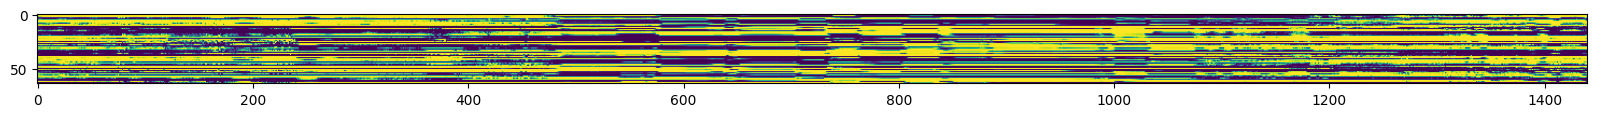

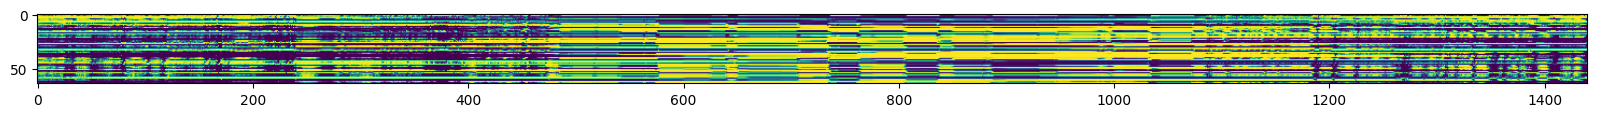

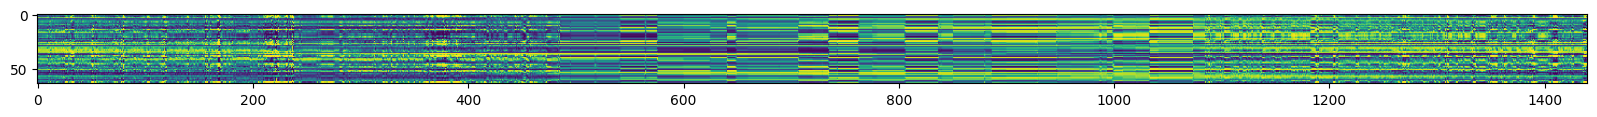

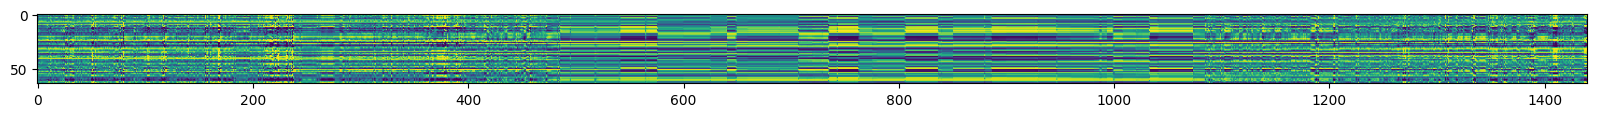

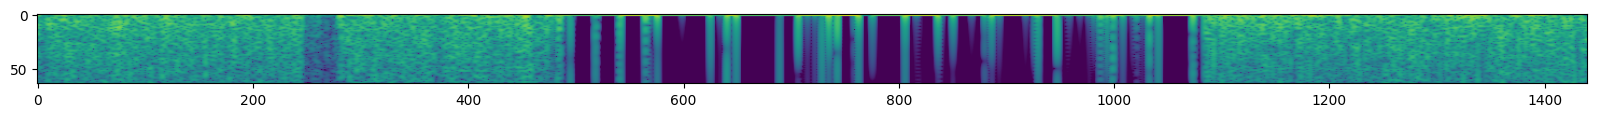

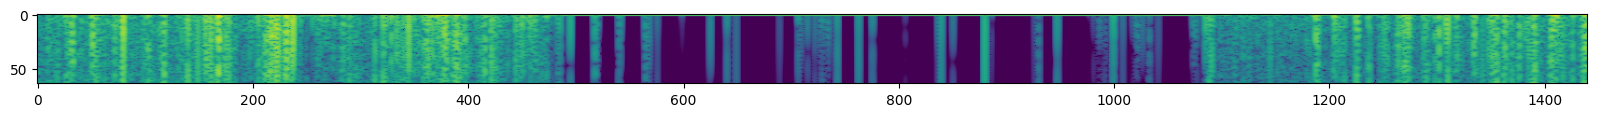

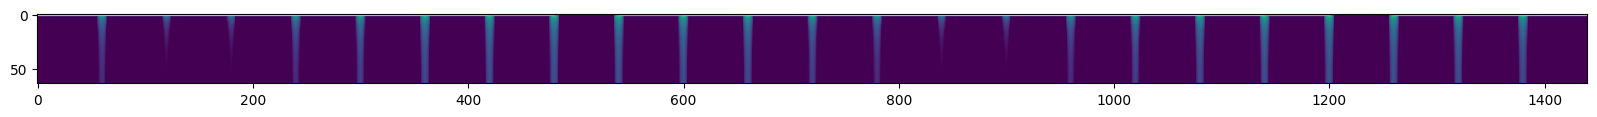

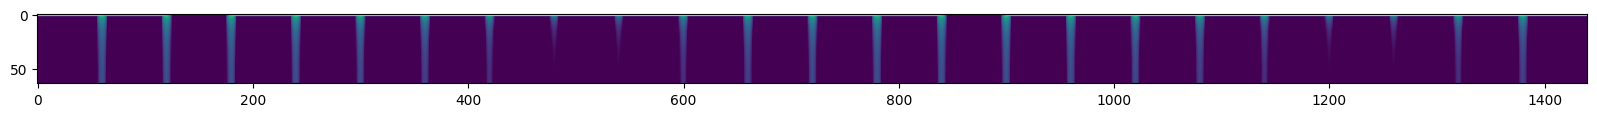

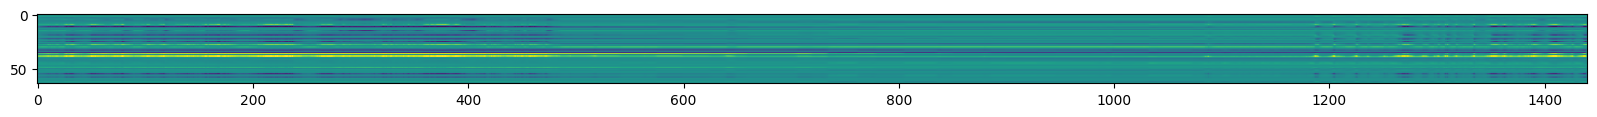

torch.Size([2, 64, 1440])


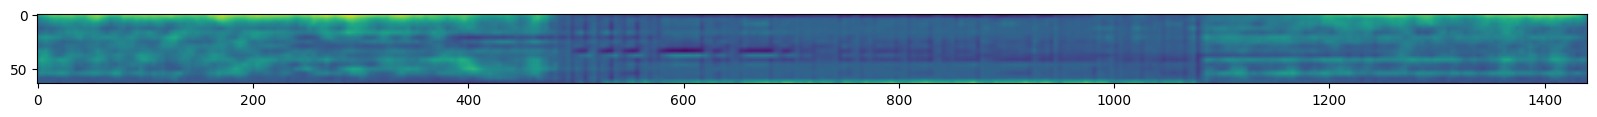

torch.Size([1440, 3])


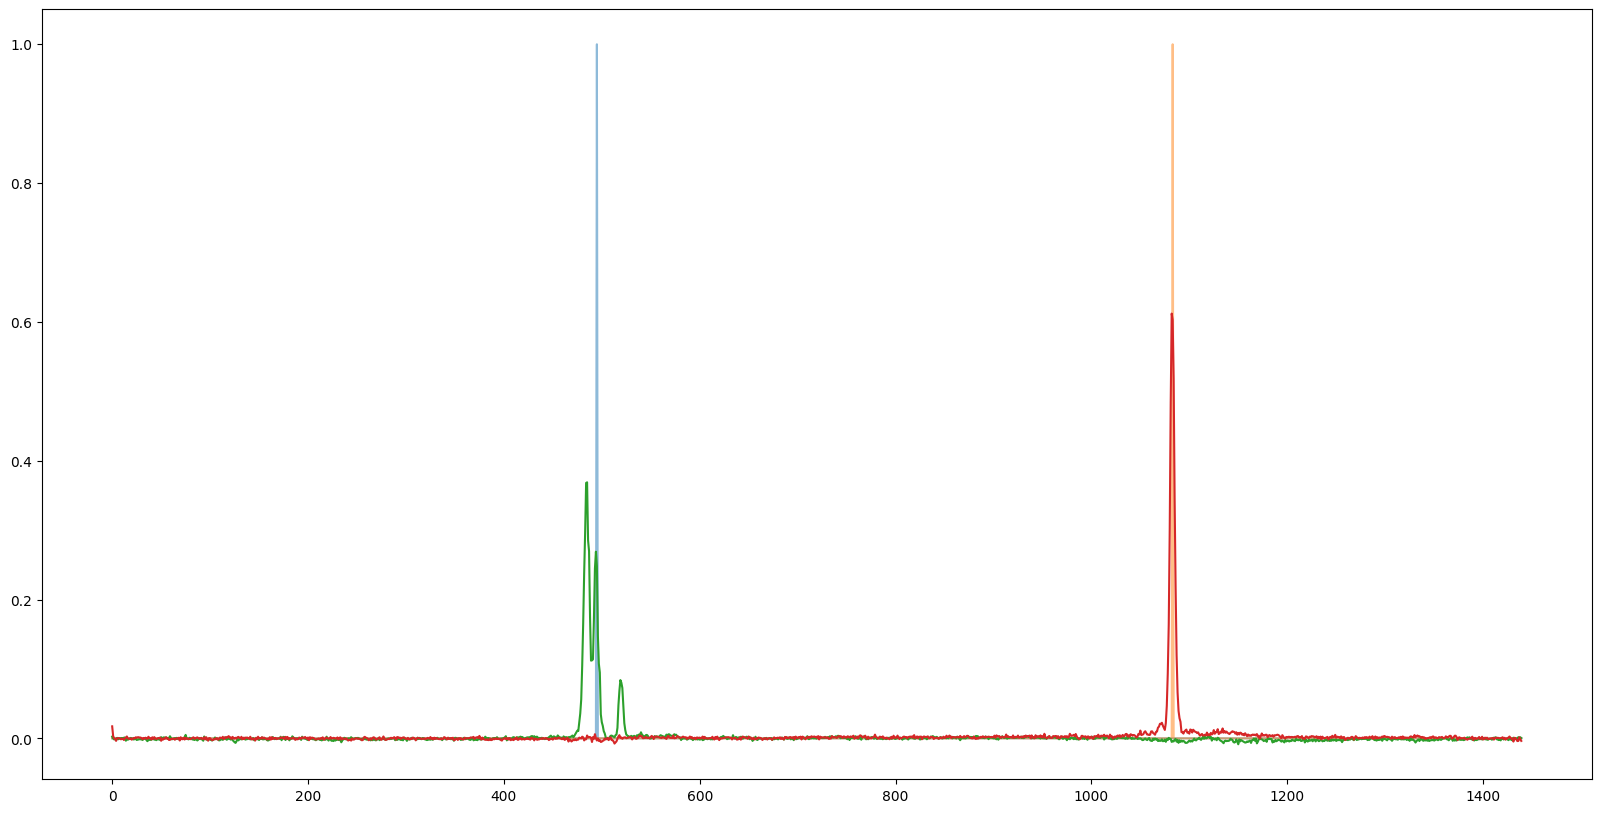

In [29]:
out = feature_extractor(x)  # (batch_size, n_channels, height, n_timesteps)
print(out.shape)
for i in range(out.shape[1]):
    plt.figure(figsize=(20, 10))
    plt.imshow(out[0, i, :, :].detach().numpy())
    plt.show()
out = encoder(out).squeeze(1)  # (batch_size, height, n_timesteps)
print(out.shape)
plt.figure(figsize=(20, 10))
plt.imshow(out[0, :, :].detach().numpy())
plt.show()
logits = decoder(out)[0]  # (batch_size, n_classes, n_timesteps)
print(logits.shape)
plt.figure(figsize=(20, 10))
plt.plot(y[:,1:], alpha=0.5)
for i in range(1,3):
    plt.plot(logits[:, i].detach().numpy())

plt.show()

torch.Size([1440, 3])


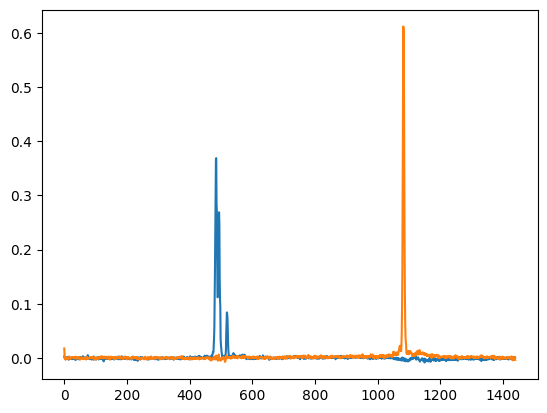

In [36]:
pred = logits
print(pred.shape)
# pred[torch.where(pred < 0.5001)] = 0
pred = pred.detach().numpy()
# plt.plot(pred[::1,])
# # plt.plot(x[1, ::cfg.downsample_rate])
# plt.show()
plt.plot(pred[::1,1:])
# plt.plot(x[1, ::cfg.downsample_rate])
plt.show()

In [43]:
np.save('pred.npy', pred[:,1:])

: 

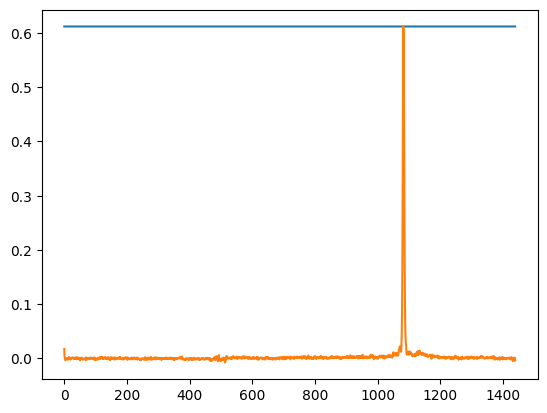

In [37]:
import numpy as np
dim = 2
plt.plot(np.ones_like(pred[:,dim])*pred[:,dim].max())
plt.plot(pred[:,dim])
plt.show()

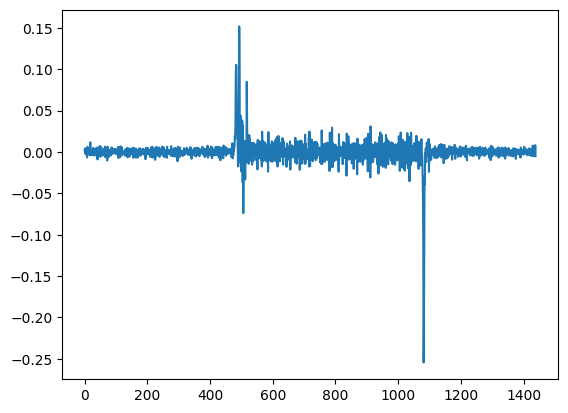

In [38]:
plt.plot(np.diff(pred[:,0]))
plt.show()

In [39]:
from scipy.signal import find_peaks
find_peaks(pred[:,2], height=0.02, threshold=0.502, distance=cfg.post_process.distance)

(array([], dtype=int64),
 {'peak_heights': array([], dtype=float64),
  'left_thresholds': array([], dtype=float64),
  'right_thresholds': array([], dtype=float64)})

In [40]:
cfg.post_process.distance

64